In [1]:
from aicastle.chat.utils import get_chat_file_hashes, load_system_text
from aicastle.chat.content_manager import OpenAIContentManager
from aicastle.chat.utils import load_config
import aicastle.chat.function_call as fc
from aicastle.chat.client import get_client, OpenAIChatManager
from aicastle.chat.tokens import (
    calculate_openai_messages_tokens_price,
    calculate_openai_finetuning_messages_tokens_price
)

from dotenv import load_dotenv

load_dotenv(
    dotenv_path='.aicastle/chat/.env', 
    override=True  # 환경변수 덮어쓰기
)

config_data = load_config()

In [2]:
chat_file_hashes = get_chat_file_hashes()
incontext_messages = []
for filepath in chat_file_hashes :
    content_manager = OpenAIContentManager(filepath)
    incontext_messages += content_manager.get_incontext_messages(
        model = config_data["model"],
        max_tokens = config_data["incontext"]["max_tokens"],
        in_text = config_data["incontext"]["in_text"],
        in_image = config_data["incontext"]["in_image"],
        info_modified = False,
    )

tokens_count, total_price = calculate_openai_messages_tokens_price(incontext_messages)
print(" ============ incontext_messages (only text) ============ ")
print(f"tokens_count: {tokens_count} / total_price: {total_price}")

chat_manager = OpenAIChatManager(
    platform = config_data["platform"],
    chat_type = config_data["chat_type"],
    model = config_data["model"],
    temperature = config_data["temperature"],
    top_p = config_data["top_p"],
    stream = config_data["stream"],
    api_version = config_data["api_version"],
    additional_system_text = load_system_text(),
    messages = incontext_messages,
    function_module=fc,
    response=True,
)


 ============ incontext_messages (only text) ============ 
tokens_count: 11795 / total_price: 41.2825


BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'messages[28].content[1].image_url.url'. Expected a valid URL, but got a value with an invalid format.", 'type': 'invalid_request_error', 'param': 'messages[28].content[1].image_url.url', 'code': 'invalid_value'}}

{'type': 'image_url',
 'image_url': {'url': {'url': ''}}}
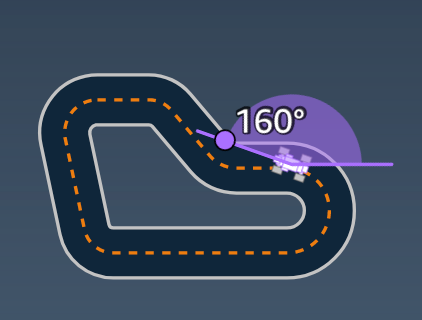

In [8]:
incontext_messages[28]['content'][1]

In [ ]:
for user_count in range(5) :
    
    ########## 유저 입력
    user_input = input("[user] ")
    print(f"[user] {user_input}")

    ########## 파일 변경 감지 
    new_chat_file_hashes = get_chat_file_hashes()
    new_incontext_messages = []
    for filepath, file_hash in new_chat_file_hashes.items() :
        
        if (not filepath in chat_file_hashes) or (chat_file_hashes[filepath] != file_hash):
            chat_file_hashes[filepath] = file_hash
            # print(filepath)

            content_manager = OpenAIContentManager(filepath)
            new_incontext_messages += content_manager.get_incontext_messages(
                model = config_data["model"],
                max_tokens = config_data["incontext"]["max_tokens"],
                in_text = config_data["incontext"]["in_text"],
                in_image = config_data["incontext"]["in_image"],
                info_modified = True,
            )
    if new_incontext_messages :
        chat_manager.add_messages(new_incontext_messages)

    ######### 유저 요청
    user_message = {"role": "user", "content": [{"type": "text","text": user_input}]}
    result_container = chat_manager.create([user_message])

    ########## assistant print
    print("[assistant] ", end="")
    while True :
        if result_container['done'] and (len(result_container['texts']) == 0):
            print()
            break
        else :
            try :
                text = result_container["texts"].pop(0)
                print(text, end="")
            except :
                pass

    ########## submit_tool
    while result_container['tool_call_need'] :
        result_container = chat_manager.submit_tool_outputs(result_container['run'])
        
        ### assistant print
        print("[assistant] ", end="")
        while True :
            if result_container['done'] and (len(result_container['texts']) == 0):
                print()
                break
            else :
                try :
                    text = result_container["texts"].pop(0)
                    print(text, end="")
                except :
                    pass
                
            